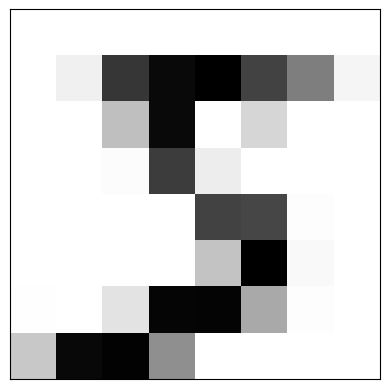

In [1]:
import MNIST_database as mnist
from matplotlib import pyplot as plt


#Choose the final size of your image dataset
size_final = 8

# data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
data_zoom = mnist.MNISTData(size_initial=20, size_final=8, color_depth=8, flat=True)

x_train= data_zoom.x_train
y_train= data_zoom.y_train
x_test= data_zoom.x_test
x_test= data_zoom.y_test

ax = plt.subplot(1, 1 , 1)

plt.imshow(x_train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [2]:
y_train.shape[-1]

10

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

BIT_WIDTH = 8

# # Replace these with your actual data
# x_train = np.random.random((100, 10))
# y_train = np.random.random((100, 10))

input_shape = (x_train.shape[-1],)

# Encoder
encoder_input = Input(shape=input_shape)
encoder_l1 = Dense(64, activation='relu')(encoder_input)
encoder_l2 = Dense(128, activation='relu')(encoder_l1)
encoder_l3 = Dense(256, activation='relu')(encoder_l2)
encoder_output = Dense(128, activation='relu')(encoder_l3)

# Decoder
decoder_l1 = Dense(256, activation='relu')(encoder_output)
decoder_l2 = Dense(128, activation='relu')(decoder_l1)
decoder_l3 = Dense(64, activation='relu')(decoder_l2)
decoder_output = Dense(y_train.shape[-1], activation='sigmoid')(decoder_l3)

# Model
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0446
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0111
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0090
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0079
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0073
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0066
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0063
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0059
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0055
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0052


In [3]:
def representative_dataset():
    for data in x_train:
        yield [np.array([data], dtype=np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quantized_tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\luisa\AppData\Local\Temp\tmp1tb4jal9\assets


In [4]:
# Save the quantized model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

model.save_weights('quantized_weights.h5')


# Load the quantized model
interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
interpreter.allocate_tensors()

# Load the saved quantized weights
model.load_weights('quantized_weights.h5')

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [5]:
# Prepare input data
input_data = np.array([x_train[0]], dtype=np.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[[-123 -126 -117 -117 -123 -105 -117 -126   47 -105]]


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

BIT_WIDTH = 8

# # Replace these with your actual data
# x_train = np.random.random((100, 10))
# y_train = np.random.random((100, 10))

input_shape = (x_train.shape[-1],)

# Encoder
encoder_input = Input(shape=input_shape)
encoder_l1 = Dense(64, activation='relu')(encoder_input)
encoder_l2 = Dense(128, activation='relu')(encoder_l1)
encoder_l3 = Dense(256, activation='relu')(encoder_l2)
encoder_output = Dense(128, activation='relu')(encoder_l3)

# Decoder
decoder_l1 = Dense(256, activation='relu')(encoder_output)
decoder_l2 = Dense(128, activation='relu')(decoder_l1)
decoder_l3 = Dense(64, activation='relu')(decoder_l2)
decoder_output = Dense(y_train.shape[-1], activation='sigmoid')(decoder_l3)

# Model
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse')

# Load the saved quantized weights
model.load_weights('quantized_weights.h5')
# model.fit(x_train, y_train, epochs=10, batch_size=32)


In [19]:
x_train.shape

(60000, 64)

In [20]:
x_test.shape

(10000, 10)

In [16]:
x_test = x_test.reshape(x_test.shape[0], -1)

In [21]:
test_imgs = x_train

ValueError: cannot reshape array of size 10 into shape (8,8)

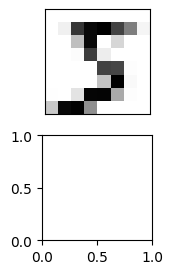

In [23]:
n = 6
plt.figure(figsize=(10, 3))
reco_imgs = model.predict(test_imgs)
img_size = int(np.sqrt(input_shape[0]))

for i in range(n):
    # Display original MNIST
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_imgs[i].reshape(
        img_size, img_size), cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed MNIST
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(reco_imgs[i].reshape(
        img_size, img_size), cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig(
    './images/QAE/reconstructed images{model_name}.png'.format(model_name=" complete"))
plt.show()